# Chapter 13: Deploying scikit-learn Models in Production
This notebook provides practical "recipes" for cross-validation and model evaluation techniques. Each recipe includes explanations, code examples, visualizations, best practices, and common pitfalls when applicable. 

Deploying a model means moving it from your development environment into production, so that real users or systems can access its predictions. Deployment involves preparing a reliable artifact, or model metadata, serving it with appropriate latency and throughput, and ensuring that it continues to perform well as the data evolves. We’ll walk through the typical steps of packaging, exposing, and verifying a trained scikit-learn model in production-like conditions.

## Getting ready
Before deployment, ensure we have a trained scikit-learn model and necessary libraries installed.

In [1]:
# Load the libraries
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from joblib import dump, load

# Create and train a simple model
X, y = make_classification(n_samples=1000, n_features=20, random_state=2024)
clf = LogisticRegression()
clf.fit(X, y)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


## How to do it...
We'll persist the model to disk and simulate loading it in a new environment (“persist” is just a way of saying we’ll save the ML model in an appropriate format for future use in a prediction setting).

In [2]:
# Save the trained model using joblib
dump(clf, "model.joblib")

# Load the model back
clf_loaded = load("model.joblib")

# Make a prediction with the loaded model
incoming = np.random.rand(1, 20)
print(clf_loaded.predict(incoming))

[1]


## How it works...
The joblib module is the recommended way to persist scikit-learn models; it handles NumPy arrays efficiently compared to standard pickle. Once exported to .joblib, the model can be uploaded to a production server and loaded by the same library versions. After loading, the model behaves identically to the original, allowing your client systems to fetch predictions reliably.

# Serialization and Persistence Techniques
Saving and reloading models is essential for production workflows—training usually happens once in a given CI/CD/CT cycle, but prediction must happen repeatedly. In this section, we’ll demonstrate how to serialize models with both `pickle` and `joblib`, discuss security and versioning considerations, and show how third party formats like ONNX may be used for Python free environments.

## Getting ready
You’ll need libraries to train a model and tools to persist it in multiple formats.

In [3]:
# Load the libraries
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import pickle
from joblib import dump, load

# Train a classifier
X, y = make_classification(n_samples=500, n_features=15, random_state=2024)
rf = RandomForestClassifier(n_estimators=10, random_state=2024)
rf.fit(X, y)

,n_estimators,10
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## How to do it...
Applying serialization with both `pickle` and `joblib` is straightforward.

In [4]:
# Serialize using pickle
with open("rf.pkl", "wb") as f:
    pickle.dump(rf, f)

# Serialize using joblib
dump(rf, "rf.joblib")

# Load the pickle model
with open("rf.pkl", "rb") as f:
    rf1 = pickle.load(f)

# Load the joblib model
rf2 = load("rf.joblib")

# Ensure identical behavior after loading
assert np.array_equal(rf.predict(X[:5]), rf1.predict(X[:5]))
assert np.array_equal(rf.predict(X[:5]), rf2.predict(X[:5]))

## How it works...
Python’s pickle library works for serializing objects but can struggle with large NumPy arrays inside estimators. joblib.dump and joblib.load are optimized for such cases and are the recommended serialization method for scikit-learn models. Note, however, that trust is required when unpickling—never use untrusted files—and that models saved with one version of scikit-learn may break if loaded with a different version. For contexts where Python is not available, converters to ONNX or PMML may be used, although these formats may not support all scikit-learn estimators.

# Scaling Models for Production
When deploying models in real-world environments, you may encounter large datasets, distributed infrastructure, or high inference demand. Here, we’ll explore techniques to scale model training and prediction, including leveraging n_jobs, joblib parallelism, connecting to external backends like Dask (https://www.dask.org/), and designing for batch serving.

## Getting ready
You’ll need tools to run parallel inference and synthetic data to benchmark performance.

In [5]:
# Load libraries
import numpy as np
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import time

# Train a forest model on synthetic data
X, y = make_classification(n_samples=2000, n_features=50, random_state=2024)
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=2024)
clf.fit(X, y)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## How to do it...
Next, let’s test.

In [6]:
# Measure single-batch latency
batch = np.random.rand(1000, 50)
start = time.time()
clf.predict(batch)
print("Time:", time.time() - start)

# Train with parallel cross-validation
scores = cross_val_score(RandomForestClassifier(n_estimators=50), X, y, cv=3, n_jobs=-1)
print("CV Accuracy:", np.mean(scores))

# (Optional) Use Dask as a joblib backend if available
# from dask.distributed import Client
# from dask_ml.model_selection import GridSearchCV as daskGSCV

Time: 0.0317533016204834
CV Accuracy: 0.8784999392195795


## How it works...
Many scikit-learn estimators support the n_jobs parameter for parallelization via joblib. For distributed environments, Dask can serve as an alternate joblib backend or support parallel meta-estimators for large workloads (basically, think of cloning your model several times across several compute/storage devices – like building an army of models). Batch serving—predicting large collections of inputs at once (i.e., in batches)—offers significantly better throughput than serving individual requests due to lower overhead and better CPU utilization.

# Monitoring and Updating Deployed Models
Once your model is live, its performance will degrade over time due to changes in input data distributions ("drift") or external conditions. This is basically a given in any scenario where an ML model is used and is not unexpected. This is where the CT in CI/CD/CT comes into play. You may be familiar with the term CI/CD, or Continuous Integration/Continuous Deployment or Deployment which is a software engineering paradigm for building and releasing software. However, in an ML deployment, we must also consider Continuous Training for monitoring and managing models as they degrade. This recipe guides you through strategies to monitor deployed models, detect drift, and update (retrain or adjust) models to maintain reliability.

## Getting ready
You’ll simulate incoming batches of data and require incremental-capable models to experiment with.

In [7]:
# Load libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import make_classification

# Simulate initial training and streaming data
X_train, y_train = make_classification(n_samples=500, n_features=10, random_state=2024)
X_pub, y_pub = make_classification(n_samples=200, n_features=10, random_state=2025)
stream_batches = np.array_split(X_pub, 4)
stream_labels = np.array_split(y_pub, 4)

## How to do it...
Next, let’s train our model in batches to simulate data evolution.

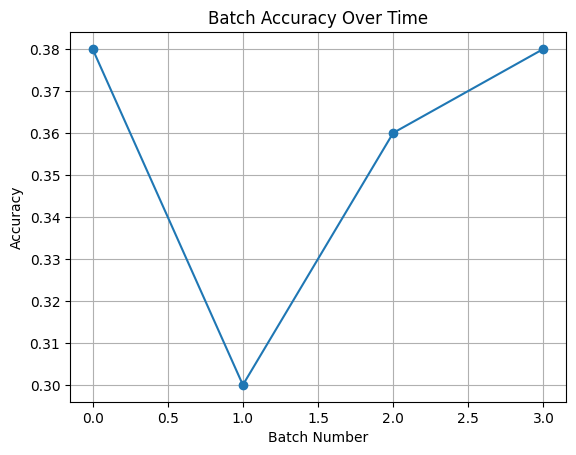

In [8]:
# Train an incremental SGDClassifier on initial data
clf = SGDClassifier(loss="log_loss", random_state=2024, warm_start=True)
clf.partial_fit(X_train, y_train, classes=np.unique(y_train))

# Monitor each incoming batch
batch_scores = []
for xb, yb in zip(stream_batches, stream_labels):
    yf = clf.predict(xb)
    batch_scores.append(np.mean(yf == yb))

# Trigger retraining when accuracy drops below threshold (e.g. < 0.8)
if min(batch_scores) < 0.8:
    clf.partial_fit(X_pub, y_pub)

# Plot batch-by-batch accuracy
plt.plot(batch_scores, marker="o")
plt.title("Batch Accuracy Over Time")
plt.xlabel("Batch Number")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

## How it works...
For models that support partial_fit and warm_start, like SGDClassifier, you can continue training as new data arrives. Monitoring batch accuracy provides a simple drift detector. If performance drops below a defined threshold, retraining the model—or updating with streaming data—can restore accuracy. Visualizing accuracy trends enables easy interpretation of degradation.

# Managing Model Lifecycle
Managing a model’s lifecycle ensures it remains reliable, reproducible, and maintainable over time. In this recipe, we cover versioning, reproducibility measures, document control, and ensuring consistency across training and serving environments.

## Getting ready
You’ll prepare a model-saving script and tools to snapshot metadata and validation outputs.

In [9]:
# Load libraries
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from joblib import dump
import json

# Train a model and simulate versioning environment
X, y = make_classification(n_samples=800, n_features=20, random_state=2024)
clf = RandomForestClassifier(n_estimators=50, random_state=2024)
clf.fit(X, y)

,n_estimators,50
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## How to do it...
Saving model artifacts is necessary for model governance over time and helps us understand the “why” and the “what” behind its performance over time.

In [10]:
from sklearn.model_selection import train_test_split

# Use X and y from cell 17 (already defined and used to train clf)
Xv, _, yv, _ = train_test_split(X, y, test_size=0.8, random_state=2024)

# Save the model artifact with versioned filename
version = "v1.0"
dump(clf, f"rf_{version}.joblib")

# Save metadata about training environment
meta = {"version": version, "sklearn": "1.3.2", "numpy": str(np.__version__)}
with open(f"rf_{version}_metadata.json", "w") as f:
    json.dump(meta, f)

# Capture validation set performance snapshot
yv_pred = clf.predict(Xv)
val_acc = accuracy_score(yv, yv_pred)
with open(f"rf_{version}_val.txt", "w") as f:
    f.write(f"{val_acc:.4f}")

## How it works...
The scikit-learn roadmap recommends snapshotting not only the model but also the code, library versions, and a small validation set with its predicted outputs, to ensure the model can be validated after future upgrades or porting. Storing metadata with each artifact helps trace back issues, roll back to previous versions, and ensure reproducibility.

# Setting Up Deployment Pipelines
Deploying models reliably requires automation. In this recipe, we’ll show how to integrate model serialization, validation checks, and serving logic into a CI/CD pipeline using scikit-learn constructs, enabling consistent transitions from development to production.

## Getting ready
You’ll need tools to train a pipeline, export it, and programmatically validate performance.

In [11]:
# Load libraries
import numpy as np
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from joblib import dump, load
from sklearn.metrics import accuracy_score

# Create data and pipeline
X, y = make_classification(n_samples=500, n_features=10, random_state=2024)
pipe = Pipeline([
    ("scale", StandardScaler()),
    ("clf", LogisticRegression())
])
pipe.fit(X, y)

,steps,"[('scale', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


## How to do it...
Let’s add in a conditional at the end of our pipeline to test an arbitrary threshold.

In [12]:
# Export the entire pipeline
dump(pipe, "pipeline.joblib")

#Load the pipeline in deployment environment
prod_pipe = load("pipeline.joblib")

# Simulate CI: validate accuracy on a test set
Xt, yt = np.random.rand(100, 10), np.random.randint(0, 2, 100)
acc = accuracy_score(yt, prod_pipe.predict(Xt))
print("Validation accuracy:", acc)

# Conditionally deploy only if accuracy > threshold (e.g. > 0.8)
if acc > 0.8:
    print("Auto-deploy allowed")
else:
    print("Halt deployment and review")

Validation accuracy: 0.53
Halt deployment and review


## How it works...
Using Pipeline ensures that preprocessing and prediction are tied together in a single object that can be validated as a unit and reused consistently across environments. This promotes repeatability and simplifies CI/CD/CT, because a single artifact includes the entire inference logic. Post-export, you can embed validation logic in your CI scripts to test the model against a small validation or canary set and only promote the model if it meets performance thresholds. This guards against “silent” regressions in deployed performance.

# Practical Exercises in Model Deployment
In this final section, we will engage in practical exercises that involve exporting and serving scikit-learn models, simulating live inference, and integrating monitoring and update strategies. These exercises are designed to consolidate our understanding of model deployment pipelines and demonstrate best practices for real-world ML operations. By the end of these exercises, we will have applied the full lifecycle of model deployment using scikit-learn.

## Exercise 1: Saving and Reloading a Model Pipeline for Deployment
In this exercise, we will serialize a trained model pipeline and reload it to simulate a production environment. This exercise ensures that preprocessing and inference logic are bundled together and reusable across environments.

### Implementation Steps:

In [13]:
# Load libraries
YOUR CODE HERE

# Create and train pipeline
YOUR CODE HERE

# Save and reload pipeline
YOUR CODE HERE

# Generate new predictions
YOUR CODE HERE

SyntaxError: invalid syntax (250648333.py, line 2)

## Exercise 2: Monitoring Model Accuracy Over Time
This exercise involves simulating streaming data and tracking a deployed model’s performance on incoming batches to detect model degradation.

### Implementation Steps:

In [ ]:
# Change the SGDClassifier hyperparameters to make the model less accurate
YOUR CODE HERE

# Plot batch accuracy
YOUR CODE HERE


## Exercise 3: Automating Deployment Checks Using Validation Thresholds
In this example, we’ll simulate a CI/CD deployment check that evaluates whether a serialized model meets performance criteria before promoting it to production.

### Implementation Steps:

In [ ]:
# Load libraries
YOUR CODE HERE

# Train and export model
YOUR CODE HERE

# Load and validate with test data
YOUR CODE HERE

# Conditionally approve deployment
YOUR CODE HERE